In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
Device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
Device

'cuda:0'

In [4]:
transform = transforms.ToTensor()
bactch_size = 8
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


In [28]:
train_iter = iter(trainset)
image, label = next(train_iter)
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [29]:
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

Ankle boot


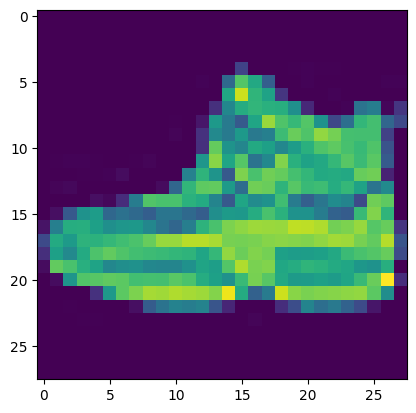

In [30]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
print(classes[label])
plt.imshow(np_img.reshape((28, 28, 1)))

In [8]:
len(trainset), len(testset)

(60000, 10000)

In [9]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [10]:
print(f'number of batches in the training set: {int(50000/bactch_size)}')


number of batches in the training set: 6250


In [11]:
type(trainset)

torch.utils.data.dataset.Subset

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bactch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=bactch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=bactch_size,
                                          shuffle=True, num_workers=2)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class fash_NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
    self.pool1 = nn.MaxPool2d(2,2)

    self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
    self.pool2 = nn.MaxPool2d(2,2)

    self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
    self.pool3 = nn.MaxPool2d(2,2)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=4096, out_features=1024)
    self.drop1 = nn.Dropout(p=0.3)

    self.fc2 = nn.Linear(in_features=1024, out_features=1024)
    self.drop2 = nn.Dropout(p=0.3)

    self.out = nn.Linear(in_features=1024, out_features=10)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)

    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.drop1(x)

    x = F.relu(self.fc2(x))
    x = self.drop2(x)

    x = self.out(x)


    return x



In [14]:
net = fash_NeuralNet()
net.to(Device)

fash_NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [15]:
for i, data in enumerate(trainloader):
  inputs, labels = data[0].to(Device), data[1].to(Device)
  print(f'input shape: {inputs.shape}')
  print(f'after network shape: {net(inputs).shape}')
  break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


**Training our CNN Classifier**

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs = 10

In [17]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_idx, data in enumerate(trainloader):
    inputs, labels = data[0].to(Device), data[1].to(Device)

    optimizer.zero_grad()

    outputs = net(inputs) # shape: [batch_size, 10]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct/bactch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_idx % 500 == 499: #printing every 500 batch
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy/500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_idx,
                                                                  avg_loss_across_batches,
                                                                  avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

print()




In [18]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(Device), data[1].to(Device)

        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / bactch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [19]:
for epoch_idx in range(epochs):
  print(f'Epoch: {epoch_idx + 1}\n')

  train_one_epoch()

  validate_one_epoch()

print("Training Done!")

Epoch: 1

Batch 499, Loss: 1.180, Accuracy: 55.0%
Batch 999, Loss: 0.725, Accuracy: 72.4%
Batch 1499, Loss: 0.614, Accuracy: 76.7%
Batch 1999, Loss: 0.607, Accuracy: 77.8%
Batch 2499, Loss: 0.560, Accuracy: 78.9%
Batch 2999, Loss: 0.507, Accuracy: 80.7%
Batch 3499, Loss: 0.505, Accuracy: 81.4%
Batch 3999, Loss: 0.459, Accuracy: 83.0%
Batch 4499, Loss: 0.473, Accuracy: 82.5%
Batch 4999, Loss: 0.445, Accuracy: 83.6%
Batch 5499, Loss: 0.429, Accuracy: 84.2%
Batch 5999, Loss: 0.405, Accuracy: 85.6%
Val Loss: 0.394, Val Accuracy: 85.2%
***************************************************

Epoch: 2

Batch 499, Loss: 0.403, Accuracy: 85.0%
Batch 999, Loss: 0.377, Accuracy: 85.7%
Batch 1499, Loss: 0.381, Accuracy: 86.0%
Batch 1999, Loss: 0.386, Accuracy: 86.0%
Batch 2499, Loss: 0.343, Accuracy: 87.2%
Batch 2999, Loss: 0.322, Accuracy: 88.0%
Batch 3499, Loss: 0.337, Accuracy: 88.1%
Batch 3999, Loss: 0.334, Accuracy: 87.8%
Batch 4499, Loss: 0.328, Accuracy: 88.2%
Batch 4999, Loss: 0.362, Accuracy

In [22]:
def test_data(testloader):
    net.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(Device), data[1].to(Device)

        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / bactch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(testloader)
    avg_acc_across_batches = (running_accuracy / len(testloader)) * 100

    print('Test Loss: {0:.3f}, Test Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [23]:
test_data(testloader)

Test Loss: 0.306, Test Accuracy: 91.1%
***************************************************

